In [1]:
# Load the dataset
words = open('names.txt', 'r').read().splitlines()
len(words)
print(f'total number of names: {len(words)}')
print(f'max length: {max(len(w)for w in words) }')
print(f'min length: {min(len(w) for w in words)}')

total number of names: 32033
max length: 15
min length: 2


In [2]:
# Helpers for tokenizing
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)} # adding one to index here so offset by 1
stoi['.'] = 0 # Special token denotes beginning or end of string
itos = {i:s for s,i in stoi.items()}

In [3]:
# Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)

In [ ]:
# ---- Bigram count model ----

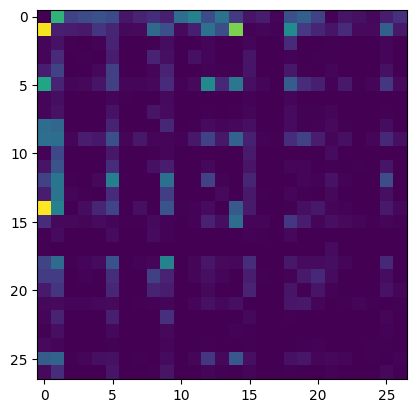

In [5]:
N = torch.zeros((27,27), dtype=torch.int32)
for w in words:
  chs = ['.'] + list(w) + ['.'] # For each word, add start and end tokens
  for ch1, ch2 in zip(chs, chs[1:]): # zip creates 2 iterators from 2 lists
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1,ix2] += 1
plt.imshow(N)

In [8]:
# Convert table of counts to table of probability distributions
# Keep note of broadcasting, keepdim and dimension summed across MATTERS
P = N.float()
P = P / P.sum(1, keepdim=True) # Divide each row by the sum of that row


In [13]:
# Sampling the model
ix = 0
for i in range(10):
  out = []

  while True:
    p = P[ix] # grab prob distribution for input character

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

selanely.
chay.
rana.
ai.
yviamisashougen.
l.
beyncaro.
allan.
annutetoradrilia.
rddeman.


In [17]:
# Compute the loss of the model
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    n += 1
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
print(f'log-likelihood: {log_likelihood}')
nll = -log_likelihood # Log likelihood is negative, loss should be positive so we can minimize
print(f'negative log-likelihood: {nll}')
print(f'normalized nll: {nll/n}') # Normalizes by number of examples to keep independent of number of examples

log-likelihood: -559891.75
negative log-likelihood: 559891.75
normalized nll: 2.454094171524048


In [ ]:
# likelihood is the product of all probabilities -> should be high as possible
# likelihood is the probability the model predicts some bigram
# summing the log of likelihoods gives the product sum of all possible bigrams in a given input
# we test the likelihood over the entire data set to understand how well the model is at predicting real bigrams
# log-likelihood is generally used because the likelihood will be tiny
# goal of training is minimize negative log-likelihood

In [18]:
# Trigram count model
T = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in words:
  chs = ['.'] + list(w) + ['.'] # For each word, add start and end tokens
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # zip creates 2 iterators from 2 lists
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    T[ix1,ix2, ix3] += 1
P = (T+1).float()
P = P / P.sum(2, keepdim=True)

In [27]:
# Sample trigram count model
for i in range(10):
  ix, iy = 0, 0
  out = []

  while True:
    p = P[ix, iy]

    iy_next  = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    out.append(itos[iy_next])

    ix, iy = iy, iy_next
    if iy == 0:
      break
  print(''.join(out))

dhimaylah.
sh.
.
daviorbtzfine.
elljhommy.
quin.
edystanah.
stinoa.
iya.
dyeth.


In [28]:
# Compute loss of trigram count model
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    n += 1
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    prob = P[ix1, ix2, ix3]
    logprob = torch.log(prob)
    log_likelihood += logprob
print(f'log-likelihood: {log_likelihood}')
nll = -log_likelihood
print(f'negative log-likelihood: {nll}')
print(f'normalized nll: {nll/n}')

log-likelihood: -410414.96875
negative log-likelihood: 410414.96875
normalized nll: 2.092747449874878


In [ ]:
# ---- Bigram Neural Network example ----

In [29]:

# create training set
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1) # input token
    ys.append(ix2) # expected output token

xs = torch.tensor(xs) # training inputs
ys = torch.tensor(ys) # training outputs


In [34]:
# (Example forward pass + loss calculation, backward pass)
# here we expect the outputs of the NN to be -inf->+inf which correlates with log counts
# we exponentiate to convert to 0->inf which is the same range as 'counts'
# then generate probabilities by diving by sum like earlier
# is there a mathematical reason that NN returns 'log-counts' beyond that the weights are randomly set in normal distribution going negative?
# it seems that logits are easier to work with mathematically, would be interesting to dive deeper here
xenc = F.one_hot(xs, num_classes=27).float()
W = torch.randn((27,27), generator=g, requires_grad=True)
logits = (xenc @ W) # log-counts
counts = logits.exp() # counts
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean() # negative log likelihood over 5 examples in probs

# backward pass
W.grad = None
loss.backward()

# update parameters
W.data += -0.1 * W.grad

loss

tensor(3.5005, grad_fn=<NegBackward0>)

In [32]:
# ---- Bigram Neural Network implementation ----

In [4]:
# instantiate weights
W = torch.randn((27,27), generator=g, requires_grad=True)

In [5]:
# create training set
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.'] # For each word, add start and end tokens
  for ch1, ch2 in zip(chs, chs[1:]): # zip creates 2 iterators from 2 lists
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1) # input token
    ys.append(ix2) # expected output token
xs = torch.tensor(xs) # training inputs
ys = torch.tensor(ys) # training outputs
num = xs.nelement()
print(f'number of examples: {num}')

number of examples: 228146


In [6]:
# gradient descent training loop
for k in range(100):
  logits = W[xs] # log-counts
  counts = logits.exp() # counts
  probs = counts / counts.sum(1, keepdims=True)
  loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean() # adding regularization term to push W towards zero
  print(loss.item())

  W.grad = None
  loss.backward()

  W.data += -25 * W.grad

3.768618583679199
3.5560057163238525
3.3962323665618896
3.2730515003204346
3.1774795055389404
3.101796865463257
3.040112018585205
2.988698959350586
2.9452340602874756
2.9081168174743652
2.8761379718780518
2.8483424186706543
2.823970317840576
2.802417039871216
2.783203125
2.765946388244629
2.750345230102539
2.736156702041626
2.7231857776641846
2.7112743854522705
2.7002925872802734
2.6901350021362305
2.6807126998901367
2.671950578689575
2.663785219192505
2.6561620235443115
2.6490323543548584
2.642355442047119
2.6360924243927
2.6302103996276855
2.6246790885925293
2.619471549987793
2.614562511444092
2.609929084777832
2.6055517196655273
2.601410388946533
2.5974888801574707
2.5937702655792236
2.590240955352783
2.5868875980377197
2.58369779586792
2.580659866333008
2.5777642726898193
2.5750014781951904
2.5723628997802734
2.569840431213379
2.5674266815185547
2.5651156902313232
2.5629000663757324
2.5607750415802
2.558734655380249
2.556774854660034
2.5548901557922363
2.553077220916748
2.551332235

In [16]:
# sampling from the model
for i in range(5):
  ix = 0
  out = []
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = W[[ix]] # log-counts
    counts = logits.exp() # counts
    p = counts / counts.sum(1, keepdims=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))

mp.
duie.
erie.
iabzitabenele.
hvemyli.


In [116]:
# ---- Trigram Neural Network implementation ----


In [66]:
W = torch.randn((54,27), generator=g, requires_grad=True)
xs, ys = [], []

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    ix3 = stoi[ch3]
    xs.append([ix1, ix2])
    ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = ys.nelement()
print(f'number of examples: {num}')

# train/test/dev split
x_train = xs[:int(0.8*num)]
y_train = ys[:int(0.8*num)]
x_dev = xs[int(0.8*num):int(0.9*num)]
y_dev = ys[int(0.8*num):int(0.9*num)]
x_test = xs[int(0.9*num):]
y_test = ys[int(0.9*num):]
x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape

number of examples: 196113


(torch.Size([156890, 2]),
 torch.Size([156890]),
 torch.Size([19611, 2]),
 torch.Size([19611]),
 torch.Size([19612, 2]),
 torch.Size([19612]))

In [67]:
# training loop
num_iters = 250
num_training_examples = y_train.nelement()
beta = 0.01
for k in range(num_iters):
  xenc = F.one_hot(x_train, num_classes=27).float().view(x_train.shape[0],-1)
  logits = (xenc @ W) # log-counts
  counts = logits.exp() # counts
  probs = counts / counts.sum(1, keepdims=True)
  loss = F.cross_entropy(logits, y_train) + beta*(W**2).mean() # adding regularization term to push W to zero
  print(loss.item())

  W.grad = None
  loss.backward()

  W.data += -25 * W.grad

4.052250862121582
3.5884921550750732
3.2960472106933594
3.1200530529022217
2.9981446266174316
2.9048235416412354
2.830775260925293
2.7709436416625977
2.7219181060791016
2.681169271469116
2.6467840671539307
2.6173295974731445
2.5917470455169678
2.5692527294158936
2.549267053604126
2.5313570499420166
2.5151922702789307
2.5005152225494385
2.48712158203125
2.474843978881836
2.463545322418213
2.453110456466675
2.4434423446655273
2.4344582557678223
2.4260876178741455
2.4182703495025635
2.4109537601470947
2.4040918350219727
2.3976452350616455
2.3915789127349854
2.385861396789551
2.380465507507324
2.375366449356079
2.3705413341522217
2.3659706115722656
2.361635446548462
2.357520341873169
2.353609085083008
2.3498880863189697
2.3463447093963623
2.3429675102233887
2.339744806289673
2.33666729927063
2.333726406097412
2.3309128284454346
2.328219175338745
2.3256378173828125
2.32316255569458
2.320786952972412
2.31850528717041
2.316311836242676
2.3142027854919434
2.3121719360351562
2.3102169036865234


In [69]:
# evaluate on dev set
xenc = F.one_hot(x_dev, num_classes=27).float().view(x_dev.shape[0],-1)
logits = (xenc @ W) # log-counts
counts = logits.exp() # counts
probs = counts / counts.sum(1, keepdims=True)
loss = F.cross_entropy(logits, y_dev)
print(loss.item())

2.444035053253174


In [64]:
# evaluate on test set
xenc = F.one_hot(x_test, num_classes=27).float().view(x_test.shape[0],-1)
logits = (xenc @ W) # log-counts
counts = logits.exp() # counts
probs = counts / counts.sum(1, keepdims=True)
loss = F.cross_entropy(logits, y_test)
print(loss.item())

2.4405388832092285


In [23]:
# sample
for i in range(5):
  out = []
  ix = 0, 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float().view(1, -1)
    logits = (xenc @ W) # log-counts
    counts = logits.exp() # counts
    p = counts / counts.sum(1, keepdims=True)

    ix_new = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix_new])
    if ix_new == 0:
      break
    ix = ix[1], ix_new

  print(''.join(out))

in.
lee.
eila.
ay.
ah.


In [24]:
# ---- Hyperparameter Optimization ----

In [73]:
def train_test_trigram(beta):
  num_training_examples = y_train.nelement()
  W = torch.randn((54,27), generator=g, requires_grad=True)
  num_iters = 125
  lr = 25

  print(beta)

  # train loop
  for k in range(num_iters):
    xenc = F.one_hot(x_train, num_classes=27).float().view(x_train.shape[0],-1)
    logits = (xenc @ W) # log-counts
    counts = logits.exp() # counts
    probs = counts / counts.sum(1, keepdims=True)
    loss = F.cross_entropy(logits, y_train) + beta*(W**2).mean()

    W.grad = None
    loss.backward()

    W.data += -lr * W.grad

  # dev loss
  xenc = F.one_hot(x_dev, num_classes=27).float().view(x_dev.shape[0],-1)
  logits = (xenc @ W) # log-counts
  counts = logits.exp() # counts
  probs = counts / counts.sum(1, keepdims=True)
  loss = F.cross_entropy(logits, y_dev)

  print(loss.item())
  return loss

In [74]:
params = torch.linspace(0.00, 0.26, steps=8, requires_grad=False)

# initialize result tensor: shape (10, 2)
results = torch.zeros(8, 2, requires_grad=False)

for i, p in enumerate(params):
    loss = train_test_trigram(p.item()).detach()
    results[i, 0] = p
    results[i, 1] = loss
results

0.0
2.4683077335357666
0.03714285418391228
2.4651007652282715
0.07428570836782455
2.4614405632019043
0.11142855882644653
2.4603397846221924
0.1485714316368103
2.4611663818359375
0.18571427464485168
2.4659979343414307
0.22285713255405426
2.4675545692443848
0.25999999046325684
2.4695322513580322


tensor([[0.0000, 2.4683],
        [0.0371, 2.4651],
        [0.0743, 2.4614],
        [0.1114, 2.4603],
        [0.1486, 2.4612],
        [0.1857, 2.4660],
        [0.2229, 2.4676],
        [0.2600, 2.4695]])

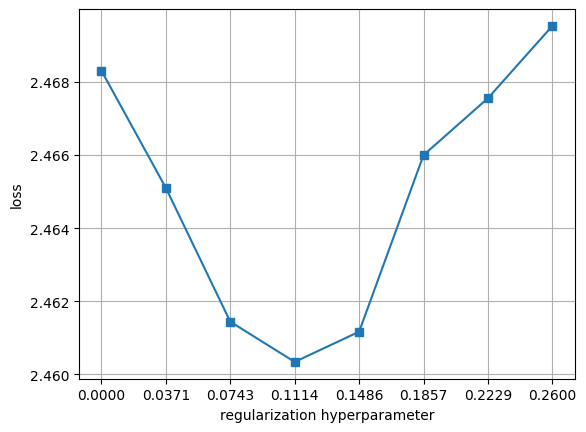

In [75]:
# plot regularization factor vs dev loss on trigram model
plt.figure(facecolor="white")
plt.plot(
    results[:, 0].numpy(),
    results[:, 1].numpy(),
    marker='s',
    linestyle='-'
)

plt.xlabel("regularization hyperparameter")
plt.ylabel("loss")

plt.xticks(results[:, 0].numpy())
plt.grid(True)

plt.show()